
# Stochastic Simulation: Random Variable Generator (RVG)

In [1]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as st
import random as rd
from operator import add

## 1. Inverse Transform Method / Direct Method / Crude Method

## 2. Rejection Method / Acceptance-Rejection Method

In [2]:
def sim_reject(fq, qs, ps, c, num:int=10):
    """Simulate realisations of discrete random variables using 
        rejection method.
    
    Keyworkd Argument
    =================
    num: Number of simulated variables.
    fq: Function to simulate realisations of discrete random 
        variables with `qs` PMF. The default value is `rd.random()`.
    qs: Probability mass function of basis random variable.
    ps: Probability mass function of desired random variable.
    """
    if not callable(fq) or not callable(qs) or not callable(ps):
        raise Exception("`fq` and `qs` must be functions!")
    
    xs = [0 for i in range(num)]
    for i in range(num):
        if_continue = True
        ## The process will continue until `xs[i]` is determined.
        while if_continue:
            y = fq()
            u = rd.random()  
            if u < ps(y) / c / qs(y):
                xs[i] = y
                if_continue = False

In [3]:
def exam_sim_reject():
    fq = rd.randint(0, 10)

In [4]:
def pmf_q_uniform(j:int):
    if j < 0 or type(j) is not int:
        raise Exception("j must be a non-negative integer!")
    elif j <= 9:
        pm = 0.1
    else:
        pm = 0
    return pm

## 2. Alias Method

In [5]:
def check_posi_pmf(li:list, if_mute=True):
    """Check if input probability mass function represented by a list is
    a `n`-point positive probability mass function."""
    if sum([i <= -0.0001 for i in li]) > 0:
        print(li)
        raise Exception("Some probability is not positive.")
    elif abs(sum(li) - 1) >= 0.001:
        raise Exception(f"Sum of PMF {sum(li):.4f} is not 100%.")
    elif not if_mute:
        print(f"The input is a {len(li)}-point positive PMF.")

In [6]:
li = [0.39, 0.2, 0.2, 0.2, 0.01]
check_posi_pmf(li, False)

The input is a 5-point positive PMF.


In [7]:
def find_ij(p):
    """Find the index i, j in the apas method for generating 
    discrete random variables.
    
    Issues
    ======
    There are many numerical issues. I have tried to solve most of them.
    Details can be found in comments.
    """
    n = len([l for l in p if l > 0.0001])

    ## Find all indices with their values smaller than 1/(n-1) and 
    ## return the first one. Note that p is considered as positive 
    ## PMF, so point with 0 probablity is not considered.
    i = [l for l, x in enumerate(p) if x < 1 / (n - 1) - 0.0001 and x > 0.0001][0]
    
    indices = [l for l, x in enumerate(p) if p[i] + x >= 1 / (n - 1) - 0.0001]
    # Note that the value to compare with must be set as ... - 0.0001
    k = 0
    ## To make sure that j != i
    while indices[k] == i:
        k += 1
    j = indices[k]
    
    ## It is easy to check the results
    if j == i or p[i] >= 1 / (n - 1) or p[i] + p[j] < 1 / (n - 1) - 0.0001:
        # Note that the value to compare with must be set as ... - 0.0001
        raise Exception("There is something wrong with the function.")
    
    ## It is very likely that `p[i]` is larger than `p[j]` in last iterations.
    ## Specifically, when it becomes a two-point PMF, either index can be 
    ## chosen as `i`. To prevent `p[i]` is larger, we can simply swap the two.
    if p[i] > p[j]:
        k = i + 0
        i = j + 0
        j = k + 0
    
    ## The index in Python starts with 0
    i += 1
    j += 1
    
    return i, j

In [8]:
def set_alias(p):
    """Set up alias for `n`-point positive probability mass function.
    
    Keyword Arguments
    =================
    p: list indicating `n`-point positive PMF
    
    Local Variables
    ===============
    ps: dict of PMF "p"
    qs: dict of PMF "q"
    qis: dict of `i` values in each iteration
    qjs: dict of `j` values in each iteration
    
    Issues
    ======
    Not sure if the `i` and `j` in the final iteration is right.
    For now, the index of the smaller one is assumed to be `i`.
    """
    check_posi_pmf(p)
    n = len(p)
    ps = {n: [l for l in p]}
    qs = {}
    qis = {}
    qjs = {}
    for k in range(1, n-1):
        i, j = find_ij(ps[n-k+1])
        qis[k] = i + 0
        qjs[k] = j + 0
        i -= 1
        j -= 1
        
        qs[k] = [0 for l in range(n)]
        qs[k][i] = (n-k) * ps[n-k+1][i]
        qs[k][j] = 1 - (n-k) * ps[n-k+1][i]
        check_posi_pmf(qs[k])
        
        ps[n-k] = [(n-k) / (n-k-1) * l for l in ps[n-k+1]]
        ps[n-k][j] = (n-k) / (n-k-1) * (ps[n-k+1][i] + ps[n-k+1][j] - 1/(n-k))
        ps[n-k][i] = 0
        check_posi_pmf(ps[n-k])
        
        ## `ps[n-k]` should be a {n-k}-point PMF
        if abs( sum(ps[n-k]) - 1 ) > 0.0001:
            raise Exception(f"There is something wrong with {n-k}-point PMF.")
        
        ## Check the iteration
        q_t = [l / (n-k) for l in qs[k]]
        p_t = [(n-k-1) / (n-k) * l for l in ps[n-k]]
        p_tt = map(add, q_t, p_t)
        t = sum( map(add, ps[n-k+1], [-l for l in p_tt]) )
        if abs(t) > 0.001:
            print(f"t = {t}.")
            raise Exception("The function is wrong.")
        
    ## Final iteration.
    k = n - 1
    qs[k] = [l for l in ps[2]]

    n_final = len([l for l in ps[2] if l > 0.0001])
    if n_final == 1:
        qis[k] = [l for l, x in enumerate(ps[2]) if x > 0.0001][0] + 1
        qjs[k] = qis[k] + 0
    else:
        i, j = find_ij(ps[2])
        qis[k] = i + 0
        qjs[k] = j + 0

    ## Convert the dict to pandas data frame.
    q_pd = pd.DataFrame.from_dict(qs, orient='index')
    q_pd.columns = [l for l in range(1, n+1)]
    
    ##
    p_pd = pd.DataFrame.from_dict(ps, orient='index')
    
    ## Test the final result
    p_new = [i / (n-1) for i in q_pd.sum().tolist()]
    delta = map(add, p, [-l for l in p_new])
    t = sum([abs(l) for l in delta])
    if abs(t) > 0.001:
        print(f"t = {t}.")
        raise Exception("The final result is wrong.")
    
    ## Add columns containing `i` and `j` information in each iteration.
    ## Note that `pandas.assign` doesn't change the original data frame directly.
    q_pd = q_pd.assign(i=[l for l in qis.values()], j=[l for l in qjs.values()])
    
    return q_pd

In [9]:
def exam_set_alias():
#     p = [7/16, 0.5, 1/16]
#     p = [7/16, 1/4, 1/8, 3/16]
    p = [0.1, 0.1, 0.2, 0.4, 0.1, 0.1]
    alias = set_alias(p)
    print(alias)
    
    
exam_set_alias()

     1    2    3    4    5    6  i  j
1  0.5  0.5  0.0  0.0  0.0  0.0  1  2
2  0.0  0.0  1.0  0.0  0.0  0.0  3  4
3  0.0  0.0  0.0  0.5  0.5  0.0  5  4
4  0.0  0.0  0.0  0.5  0.0  0.5  6  4
5  0.0  0.0  0.0  1.0  0.0  0.0  4  4


In [10]:
def run_alias(alias):
    n = alias.shape[0] + 1
    int_sim = rd.randint(1, n-1)
    u = rd.random()
    i_sim = alias['i'][int_sim]
    j_sim = alias['j'][int_sim]
    
    if u < alias[i_sim][int_sim]:
        x = i_sim
    else:
        x = j_sim
    
    return x

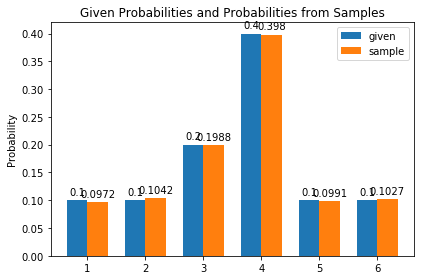

In [11]:
def exam_run_alias():
    num_sim = 10000
#     p = [7/16, 1/4, 1/8, 3/16]
    p = [0.1, 0.1, 0.2, 0.4, 0.1, 0.1]
    n = len(p)
    alias = set_alias(p)
    
    xs = [run_alias(alias) for l in range(num_sim)]
    p_sample = [xs.count(l) / num_sim for l in range(1, n+1)]
    
    ## Start plotting.
    labels = [l for l in range(1, n+1)]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, p, width, label='given')
    rects2 = ax.bar(x + width/2, p_sample, width, label='sample')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Probability')
    ax.set_title('Given Probabilities and Probabilities from Samples')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()


exam_run_alias()

## 3. Chi-Squared Goodness-of-Fit Test of Samples

In [12]:
def test_dist(pvalue:float, alpha:float=0.05):
    """Perform distribution test."""
    print("Null hypothesis: two populations have the same distribution. \n" 
        f"The input p value is {pvalue:.4f}. \n"
        f"Is the p value smaller than {alpha}? {pvalue < alpha}. \n" 
        f"If reject the null hypothesis? {pvalue <= 0.05}. \n" 
        f"If from the same distribution? {pvalue >= 0.05}. \n")

The function `cal_stat_gof` is a bit different from that in `RNG.ipynb`

In [13]:
def cal_stat_gof(li_count, li_cdf):
    """Calculate the statistic in Goodness of Fit test."""
    li_p = [li_cdf[0]] + [li_cdf[i] - li_cdf[i-1] for i in range(1, len(li_cdf))]
    n = sum(li_count)
    k = len(li_p)
    stat = sum( [(li_count[i] - n * li_p[i])**2 / n / li_p[i] for i in range(k)] )
    print(f"Chi-squared goodness of fit test: {stat:.4f}.")
    
    return stat

In [14]:
def cal_pvalue_chi2(stat, df):
    """Calculate the pvalue of two-sided t-test using Chi-Square distribution."""
    pvalue = 1 - st.chi2.cdf(stat, df)
    print(f"The input stat: {stat:.4f}. \n"
        f"The p value from Chi-Square distribution: {pvalue:.4f}.")
    return pvalue

In [15]:
num_sim = 10000
#     p = [7/16, 1/4, 1/8, 3/16]
p = [0.1, 0.1, 0.2, 0.4, 0.1, 0.1]
n = len(p)
alias = set_alias(p)

xs = [run_alias(alias) for l in range(num_sim)]
li_count = [xs.count(l) for l in range(1, n+1)]

li_cdf = [0.1, 0.2, 0.4, 0.8, 0.9, 1]
stat = cal_stat_gof(li_count, li_cdf)
pvalue = cal_pvalue_chi2(stat, df=5)
test_dist(pvalue)

Chi-squared goodness of fit test: 6.0765.
The input stat: 6.0765. 
The p value from Chi-Square distribution: 0.2988.
Null hypothesis: two populations have the same distribution. 
The input p value is 0.2988. 
Is the p value smaller than 0.05? False. 
If reject the null hypothesis? False. 
If from the same distribution? True. 

